In [1]:
import numpy             as np
import math
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import glob
import h5py as h
import random
import statistics as st
import seaborn as sn
import pandas as pd

%matplotlib inline

In [2]:
        
def getvalues(file):
    data = h.File(file,'r')
    return data['MC']

def getParticles(file,EventLimit=0,particle=b'opticalphoton'):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(EventLimit>0):
        TotalEvents=EventLimit
    
    theEvents={}
    
    FudicalCount=0
    ElectronHits={}
    
    
    for Current_Event in range(0,TotalEvents):
        
        Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event
        Current_Particles=data['MC']['particles'][Current_Particle_Mask]
        
        Photon_Mask = Current_Particles['particle_name'] == b'opticalphoton'
        
        #print(data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_x"])
        X=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_x"]
        Y=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_y"]
        Z=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_z"]
        Volume=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["final_volume"]
        E=data['MC']['particles'][Current_Particle_Mask][Photon_Mask]["kin_energy"]


        Pos=np.array([X,Y,Z])
        theEvents[Current_Event]=[Pos,Volume,E]
    return theEvents

def MultiFileIonizationElectronPosition(files,mother,TargetVolume=b'EL_GAP',TargetParticle=b'opticalphoton',EventLimit=2,FileName="Optical.p"):
    count=0
    values={}
    
    if(EventLimit==-1):
        EventLimit=len(files)
    filecount=0
    for file in files:
        print(f"Analyzing following  file --> {file}\n" )
        data = getvalues(file)
        TotalEvents=int(data['configuration'][2][1])
        FinalPosition={"particle_name":[],"x":[],"y":[],"z":[]}
    
        for EventID in range(0,TotalEvents):
            #Obtain current event id
            EventIDMask=data["particles"]["event_id"]==EventID
            
            #Store particle infor for this event
            ParticlesTable=data["particles"][EventIDMask]
            
            #Create Mother mask for expected mother
            MotherMask=ParticlesTable["particle_name"]==mother
            
            ## Particle Name Mask
            
            #Interested particles
            ParticleNameMask=ParticlesTable["particle_name"]==TargetParticle
            ParticlesInInterest=ParticlesTable[ParticleNameMask]
            if(TargetVolume!=None):
                IonizationElectronsMask=ParticlesInInterest["final_volume"]==TargetVolume
                ParticlesInInterest=ParticlesInInterest[IonizationElectronsMask]
           
            IonizationElectronMotherID=ParticlesInInterest["mother_id"]

            #Expected Mother IDs
            ExpectedMotherID=ParticlesTable["particle_id"][MotherMask]
            
            #Find intersection of the motherIds of ie and Expected Mother
            MotherIDMask=np.isin(IonizationElectronMotherID,ExpectedMotherID)
            FinalPosition["particle_name"]=ParticlesInInterest["particle_name"][MotherIDMask]
            FinalPosition["x"]=ParticlesInInterest["final_x"][MotherIDMask]
            FinalPosition["y"]=ParticlesInInterest["final_y"][MotherIDMask]
            FinalPosition["z"]=ParticlesInInterest["final_z"][MotherIDMask]
            values[count]=FinalPosition
            count=count+1
            
        if(filecount>=EventLimit):
            break
        filecount=filecount+1
    if(FileName=="" or FileName=="None"):
        pass
    else:
        PickleITDump(values,FileName+".p")
    print("Events are saved!")
    return values




In [3]:
Data=getParticles("/media/ilker/Ilker/CRAB/Simulation/optical.h5")

In [4]:
print(Data[0][1])

[b'ELPP_Mesh_Logic' b'EL_GAP' b'ELP_Mesh_Logic' ... b'EL_GAP' b'EL_GAP'
 b'ELP_Mesh_Logic']


In [5]:
DataMask=Data[0][1]==b'Anode_PHOTOCATHODE'
print(len(Data[0][1][DataMask])*0.11)

0.55


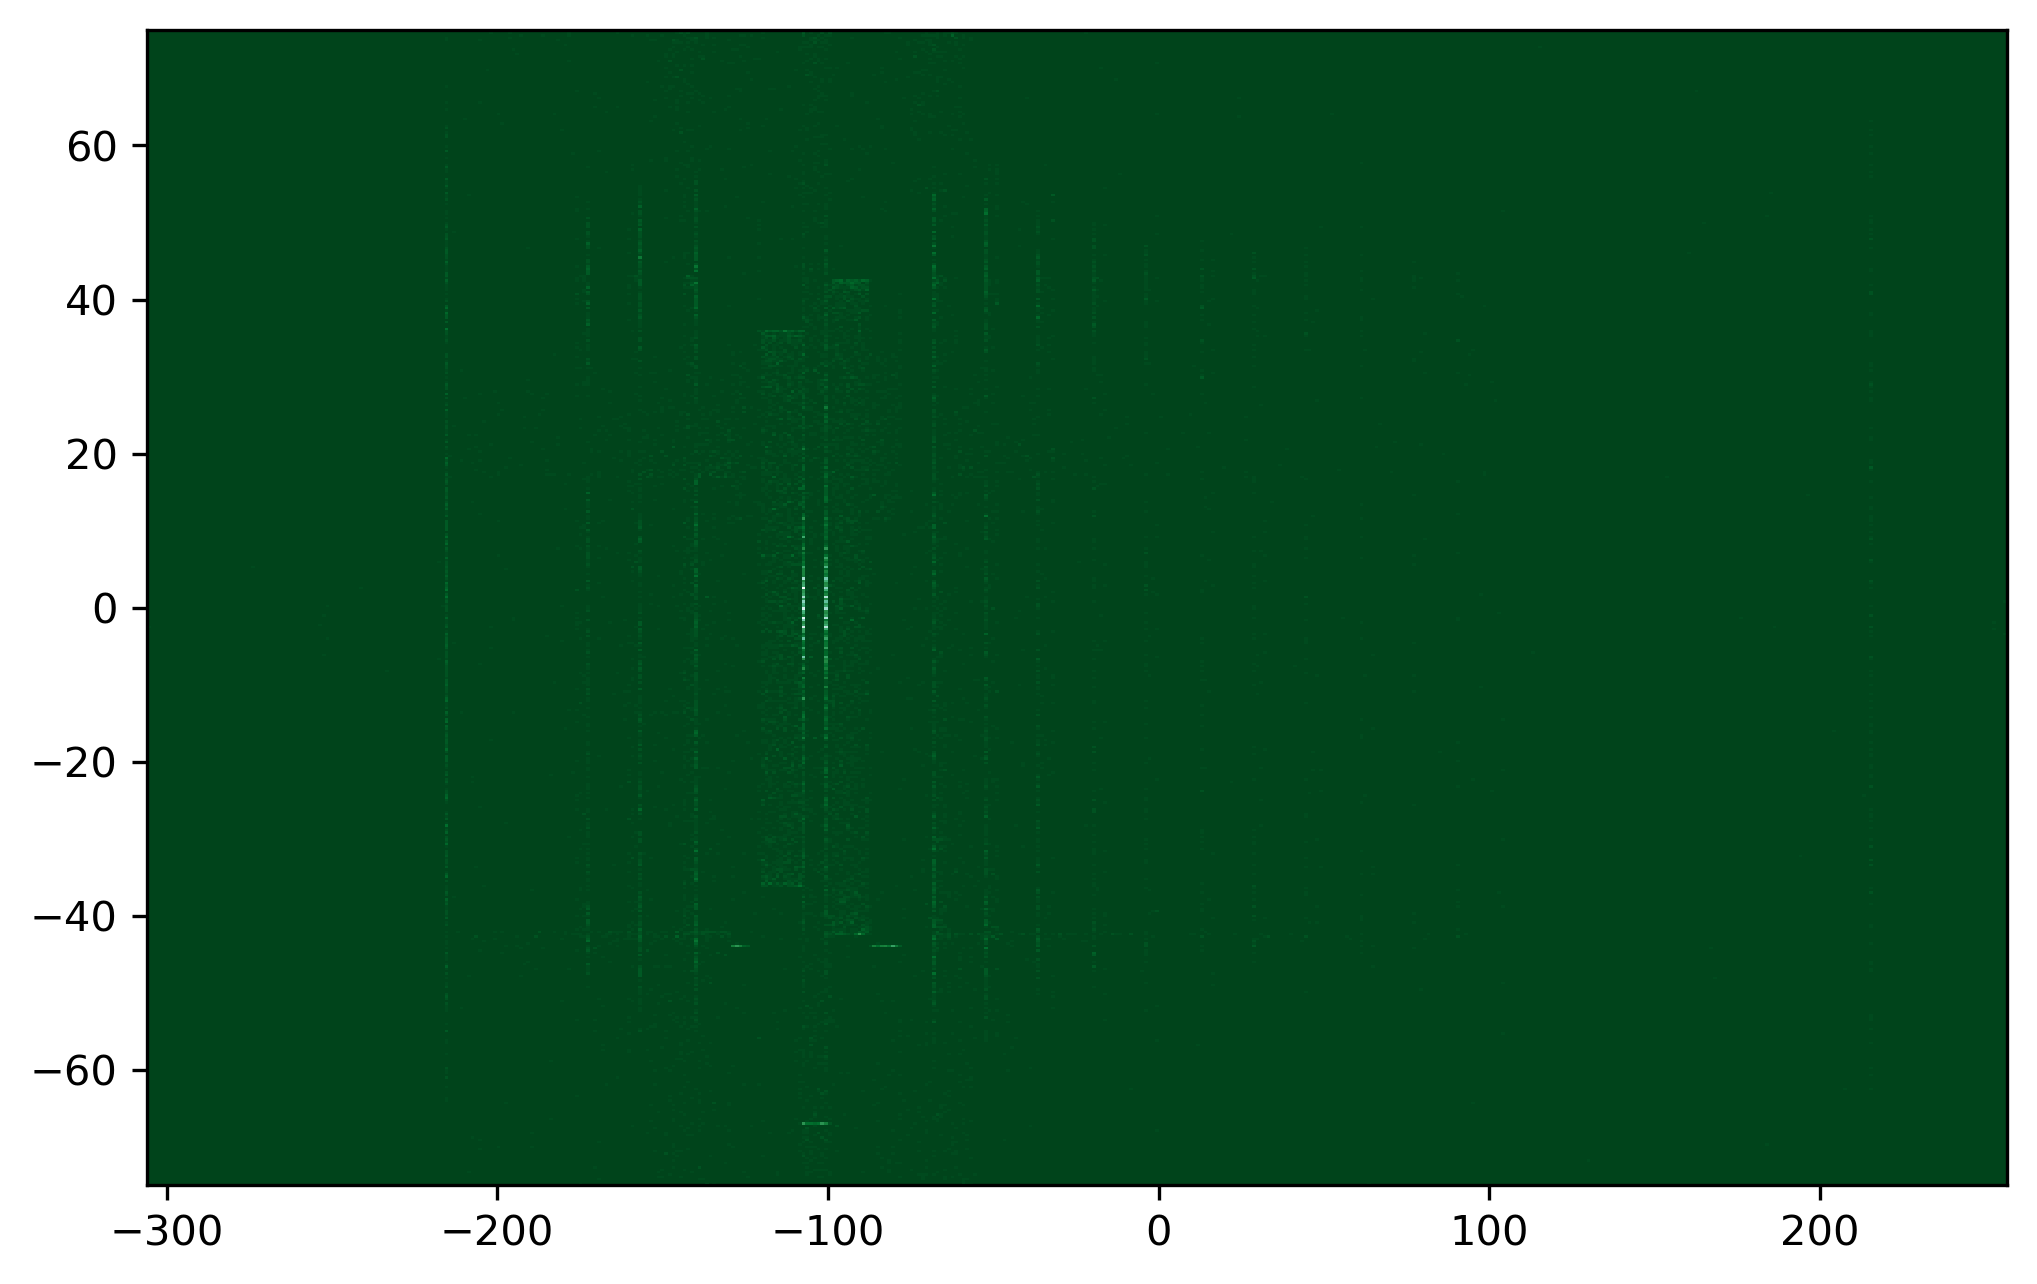

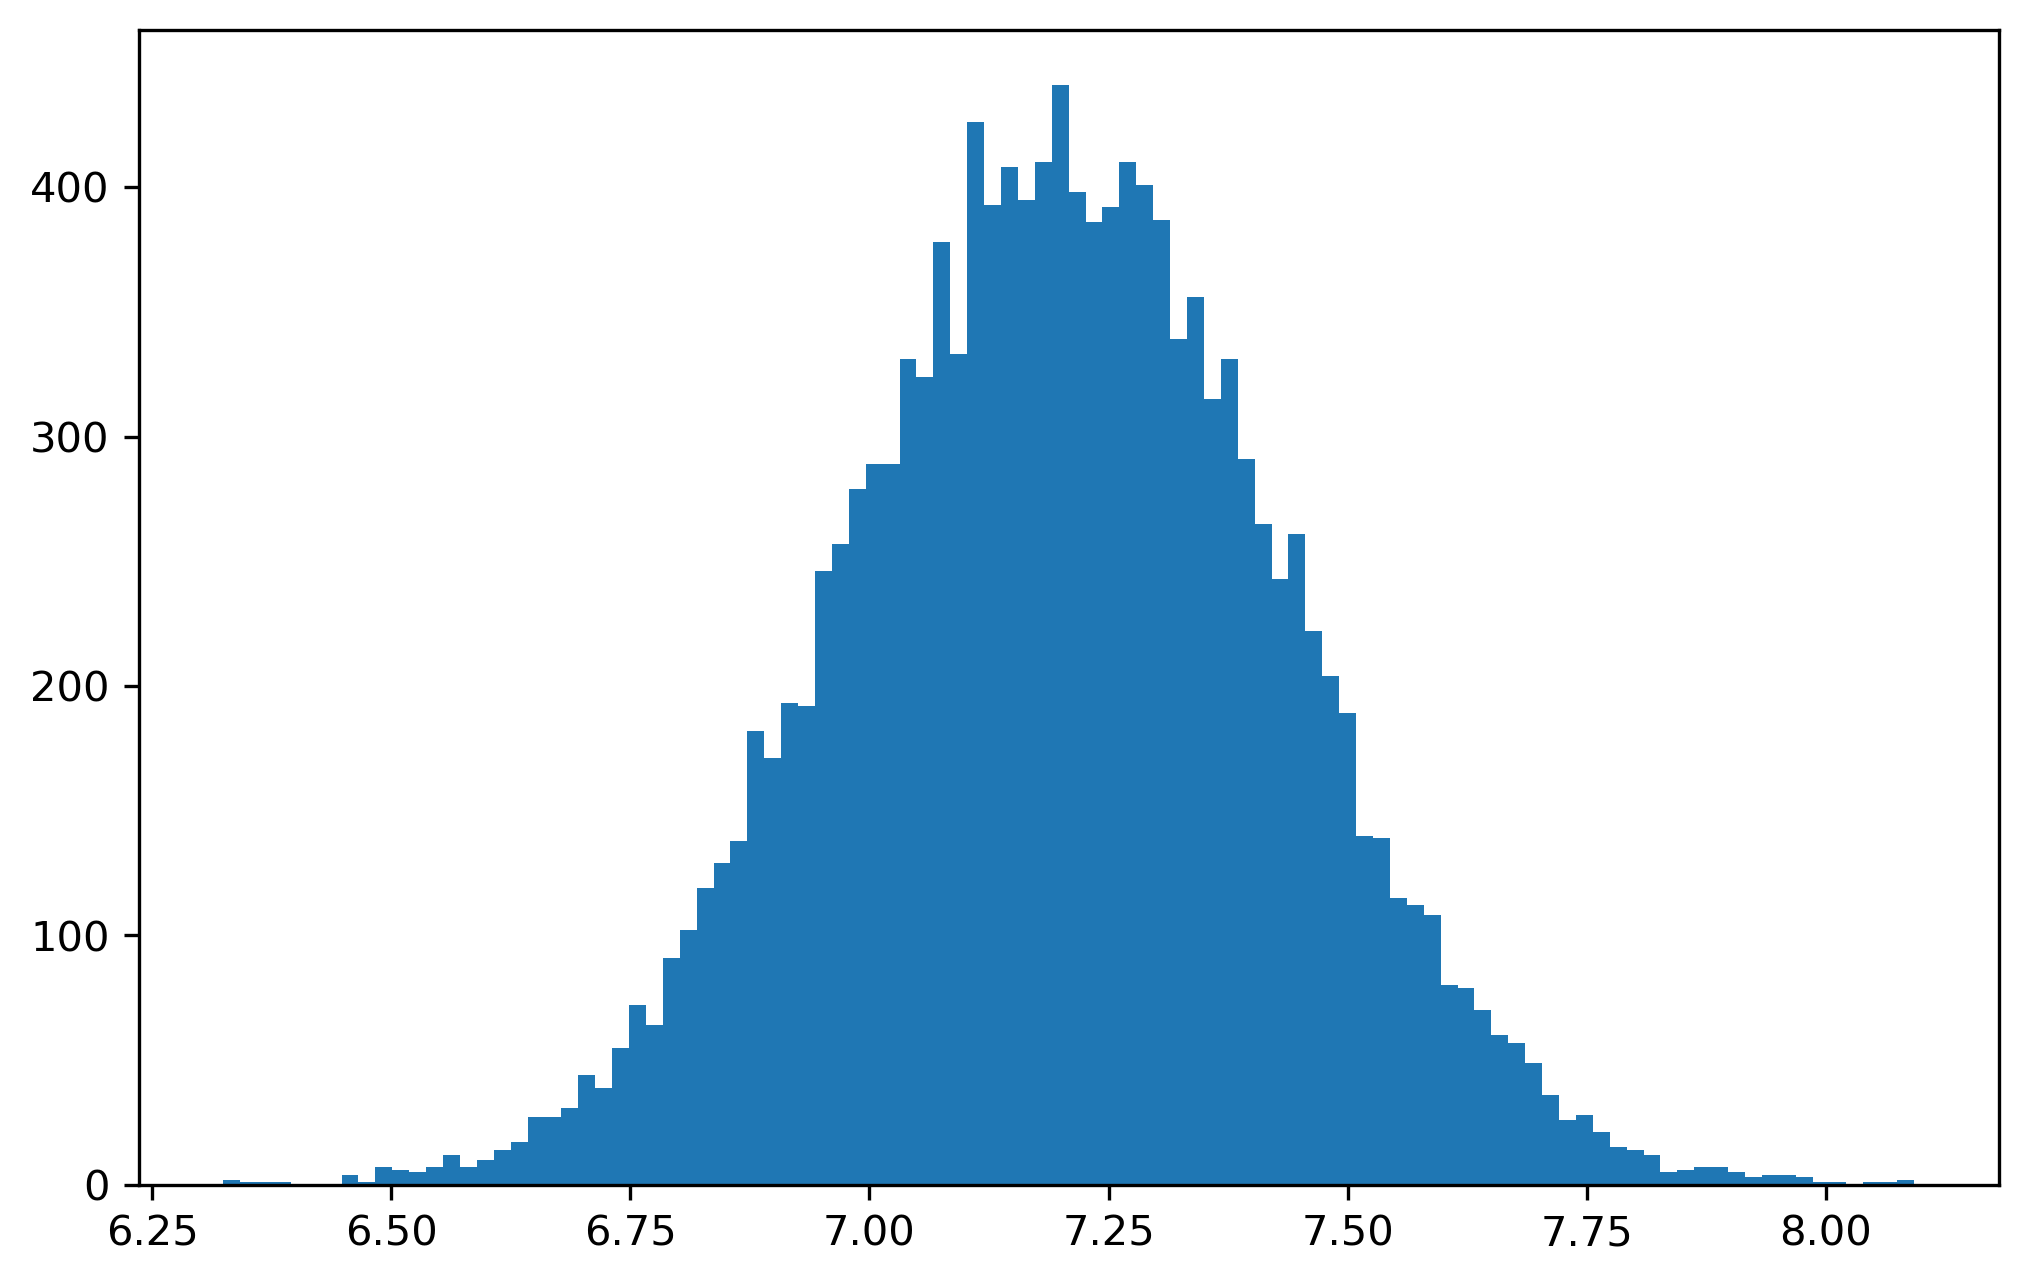

 Mean --> 172.3300018310547 FWHM --> 13.04 


In [6]:

plt.figure(figsize=(8,5),dpi=300)
plt.hist2d(Data[0][0][2],Data[0][0][1],bins=(500,500),cmap=plt.cm.BuGn_r)
plt.show()
plt.figure(figsize=(8,5),dpi=300)
E=Data[0][2]*1e6 ### Conversion from MegaElectronVolt GEANT4 Thing
plt.hist(E,bins=100)
plt.show()
E=(1239.8/E)
mean=(np.mean(E))
FWHM=2.355*np.std(E)
#stdev=st.stdev(np.array(Data[0][2]))
print(f" Mean --> {round(mean,2)} FWHM --> {round(FWHM,2)} ")

In [7]:
L172nm=pd.read_hdf("/media/ilker/Ilker/CRAB/Simulation/Alpha_Gaussian_172nm_1000events.h5","MC/particles")


In [8]:
L170nm=pd.read_hdf("/media/ilker/Ilker/CRAB/Simulation/Alpha_Gaussian_170nm_1000events.h5","MC/particles")


In [9]:
L172nm["final_volume"].value_counts()

FR                        2399884
EL_GAP                    2107542
CHAMBER                   1352130
ELPP_Mesh_Logic            753714
ELP_Mesh_Logic             735590
CHAMBER_FLANGE_ANODE       434240
PEEK_Rod                   382491
bracketPhysical            342597
CHAMBER_FLANGE_CATHODE      75328
Cathode_Mesh_Logic          10412
Anode_PHOTOCATHODE           7157
EL_MeshP                     4504
Needle                       3303
LAB                          2918
GAS                          2239
Anode_WINDOW                 1654
PMT_TUBE1                    1551
Cathode_PHOTOCATHODE         1181
FIELDCAGE                    1000
Anode                         928
Cathode_WINDOW                235
Cathode                       118
PMT_TUBE0                      49
Name: final_volume, dtype: int64

In [10]:
L170nm["final_volume"].value_counts()

FR                        2374115
EL_GAP                    2085422
CHAMBER                   1336281
ELPP_Mesh_Logic            743774
ELP_Mesh_Logic             725336
CHAMBER_FLANGE_ANODE       429121
PEEK_Rod                   377009
bracketPhysical            336473
CHAMBER_FLANGE_CATHODE      74594
Cathode_Mesh_Logic          10200
Anode_PHOTOCATHODE           6507
EL_MeshP                     4437
Needle                       3369
LAB                          2889
Anode_WINDOW                 2375
GAS                          2311
PMT_TUBE1                    1546
Cathode_PHOTOCATHODE         1127
FIELDCAGE                    1000
Anode                         797
Cathode_WINDOW                307
Cathode                        72
PMT_TUBE0                      43
Name: final_volume, dtype: int64

In [11]:
L172nm_2cm=pd.read_hdf("/media/ilker/Ilker/CRAB/Simulation/Alpha_Gaussian_170nm_1000events_2cm_.h5","MC/particles")


In [12]:
L172nm_2cm["final_volume"].value_counts()

FR                        2349399
EL_GAP                    2065068
CHAMBER                   1322447
ELPP_Mesh_Logic            735408
ELP_Mesh_Logic             720839
CHAMBER_FLANGE_ANODE       425164
PEEK_Rod                   374851
bracketPhysical            334826
CHAMBER_FLANGE_CATHODE      73474
Cathode_Mesh_Logic          10025
Anode_PHOTOCATHODE           6925
EL_MeshP                     4544
Needle                       3325
LAB                          2870
GAS                          2455
Anode_WINDOW                 1742
PMT_TUBE1                    1421
Cathode_PHOTOCATHODE         1125
FIELDCAGE                    1000
Anode                         903
Cathode_WINDOW                218
Cathode                        99
PMT_TUBE0                      38
Name: final_volume, dtype: int64

In [13]:
L172nm_2cmv2=pd.read_hdf("/media/ilker/Ilker/CRAB/Simulation/Alpha_Gaussian_172nm_1000events_2cm_.h5","MC/particles")


In [14]:
L172nm_2cmv2["final_volume"].value_counts()

FR                        2368540
EL_GAP                    2083919
CHAMBER                   1333122
ELPP_Mesh_Logic            743152
ELP_Mesh_Logic             727227
CHAMBER_FLANGE_ANODE       428103
PEEK_Rod                   377673
bracketPhysical            338471
CHAMBER_FLANGE_CATHODE      73943
Cathode_Mesh_Logic          10064
Anode_PHOTOCATHODE           6929
EL_MeshP                     4458
Needle                       3230
LAB                          2889
GAS                          2257
Anode_WINDOW                 1738
PMT_TUBE1                    1479
Cathode_PHOTOCATHODE         1172
FIELDCAGE                    1000
Anode                         885
Cathode_WINDOW                247
Cathode                       116
PMT_TUBE0                      35
Name: final_volume, dtype: int64

In [15]:
L172nm_noabs=pd.read_hdf("/media/ilker/Ilker/CRAB/Simulation/Alpha_Gaussian_172nm_1000events_2cm_NoABS.h5","MC/particles")


In [16]:
L172nm_noabs["final_volume"].value_counts()

Series([], Name: final_volume, dtype: int64)

In [17]:
#Data2=getParticles("/media/ilker/Ilker/CRAB/Simulation/For_Nick/WithNicksYieldv2.h5")